In [1]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [2]:
import torch
import torch.nn as nn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import cv2
import os
import torchvision.transforms as transforms
import torchvision.datasets as dset
import matplotlib.pyplot as plt
import torch.optim as optim
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from sklearn.preprocessing import OneHotEncoder

In [3]:
!pwd


/content


In [4]:
df=pd.read_csv('DL-ClassProject-Data.csv')

In [5]:
df.head()

,File Name,Face Shape,Type of Lip,Color of Lip,Forehead,Cheeks with Dimple,Ear,Eye Size,Eye Defect,Eye Color,...,Eyebrow Separation,Jaw Line,Skin Color,Hair Color,Hair Style,Beard Mustache Style,Nose,Age (Rough estimate as appearing),Gender,Identification mark if any (describe)
0,S1.jpeg,Diamond,Heavy lower lips,Pink,Fuzzi-Mount,Yes,pointed ear,Big Eye,No visible defect,Brown,...,High Seperated,Sharp,Fair,Black,Long hair girl,Shaven,Straight,32,Female,No
1,S50.jpeg,Rectangle,Heavy lower lips,Black,Broad,No,narrow ear,Medium Eye,No visible defect,Black,...,Seperated,Flat,Dark,Black,Half Bald,Shaven,Raised,18,Male,na
2,S53.jpg,Oblong,Thin lips,Pink,Straight,No,Broad lobe,Medium Eye,No visible defect,Gray,...,Seperated,Flat,White,Black and white mixed,Medium length male,Shaven,Lowered,50,Male,Non
3,S54.jpeg,Diamond,Heavy upper lips,Pink,Broad,No,pointed ear,Medium Eye,No visible defect,Gray,...,Seperated,Sharp,White,Golden,Long hair girl,Shaven,Straight,32,Female,NaN
4,S52.jpeg,Diamond,Heavy lower lips,Pink,Straight,Yes,Broad lobe,Big Eye,No visible defect,Black,...,High Seperated,Sharp,Fair,Black,Long hair girl,Shaven,Straight,31,Female,No


In [6]:
df=df.drop(['Identification mark if any (describe)', 'Eye Defect'], axis=1)

In [7]:
y_col=['File Name']

In [8]:
cat_cols=['Face Shape', 'Type of Lip', 'Color of Lip', 'Forehead', 'Cheeks with Dimple', 'Ear', 'Eye Size', 'Eye Color', 'Eyebrow Style', 'Eyebrow Separation', 'Jaw Line', 'Skin Color', 'Hair Color', 'Hair Style', 'Beard Mustache Style', 'Nose', 'Gender']
cont_cols=['Age (Rough estimate as appearing)']

In [9]:
df=df[df['Age (Rough estimate as appearing)'] != 'None']

In [10]:
for cat in cat_cols:
  df[cat]=df[cat].astype('category')

In [11]:
for cat in cat_cols:
  df[cat]=df[cat].cat.codes

In [12]:
enc=OneHotEncoder()

In [13]:
enc_data=pd.DataFrame(enc.fit_transform(df[cat_cols]).toarray())

In [14]:
df=df.join(enc_data)

In [15]:
cats=np.stack([df[cat].values for cat in range(0, 88)], 1)

In [17]:
cats=torch.tensor(cats, dtype=torch.int64)

In [18]:
df['Age (Rough estimate as appearing)']=df['Age (Rough estimate as appearing)'].convert_dtypes()

In [19]:
for row in df.index:
  val=df.loc[row, 'Age (Rough estimate as appearing)']
  if val.find('-')!=-1:
    lb=int(val.split('-')[0])
    ub=int(val.split('-')[1])
    df.loc[row, 'Age (Rough estimate as appearing)']=str((lb+ub)//2)

In [20]:
df['Age (Rough estimate as appearing)']=df['Age (Rough estimate as appearing)'].astype(str).astype(int)

In [21]:
df['Age (Rough estimate as appearing)'].dtypes

dtype('int64')

In [22]:
conts = np.stack([df[col].values for col in cont_cols], 1)
conts = torch.tensor(conts, dtype=torch.float)

In [23]:
conts[:5]

tensor([[32.],
        [18.],
        [50.],
        [32.],
        [31.]])

In [24]:
cats

tensor([[                   1,                    0,                    0,
          ...,                    1,                    0,
                            0],
        [                   0,                    0,                    0,
          ...,                    0,                    1,
                            0],
        [                   0,                    0,                    1,
          ...,                    0,                    1,
                            0],
        ...,
        [                   0,                    0,                    0,
          ...,                    0,                    1,
                            0],
        [                   0,                    0,                    0,
          ...,                    0,                    1,
                            0],
        [-9223372036854775808, -9223372036854775808, -9223372036854775808,
          ..., -9223372036854775808, -9223372036854775808,
         -9223372036854

In [25]:
image_list = []
filePath='/content/gdrive/MyDrive/Images'
for fileName in df['File Name']:
  # print(fileName)
  # print(os.path.join(filePath,fileName))
  img = cv2.imread(os.path.join(filePath,fileName))
  # print(img)
  if img is not None:
    image_list.append(img)

In [26]:
len(image_list)

977

In [27]:
image_list[0].shape

(1490, 1000, 3)

In [28]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((256, 256)),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

In [31]:
imageTensors=torch.tensor(())
for img in image_list:
  tensor_img=transform(img)
  tensor_img=tensor_img.unsqueeze(0)
  imageTensors=torch.cat((imageTensors, tensor_img), 0)

In [32]:
imageTensors.shape

torch.Size([977, 3, 256, 256])

In [33]:
imageTensors[0].shape

torch.Size([3, 256, 256])

In [35]:
len(cats)
cats.shape

torch.Size([977, 88])

In [36]:
len(conts)
conts.shape

torch.Size([977, 1])

In [37]:
len(imageTensors)

977

In [38]:
x=torch.cat((cats, conts), 1)

In [40]:
x=x.numpy()
imageTensors=imageTensors.numpy()

In [41]:
x_train, x_test, y_train, y_test = train_test_split(x, imageTensors)

In [43]:
x_train=torch.from_numpy(x_train)
x_test=torch.from_numpy(x_test)
y_train=torch.from_numpy(y_train)
y_test=torch.from_numpy(y_test)

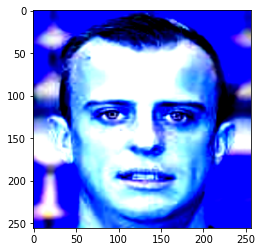

In [45]:
plt.imshow(np.transpose(y_train[0].numpy(), (1, 2, 0)));

In [46]:
def resize(tens):
  # tens.unsqueeze_(0)
  tens.unsqueeze_(1)
  tens.unsqueeze_(2)
  return tens

In [48]:
import os
import pandas as pd
from torchvision.io import read_image

class CustomDataset(Dataset):
    def __init__(self, x, y):
        self.x=x
        self.y=y

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
                 
        image = self.y[idx]
        label = self.x[idx]
        label=resize(label)
        
        return label, image  
        
        

In [49]:
training_data=CustomDataset(x_train, y_train)

In [50]:
test_data=CustomDataset(x_test, y_test)

In [51]:
train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

In [54]:
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( 89, 1024, 4, 1, 0, bias=False),
            nn.BatchNorm2d(1024),
            nn.ReLU(True),
            # 
            nn.ConvTranspose2d(1024, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            # 
            nn.ConvTranspose2d( 512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            # 
            nn.ConvTranspose2d( 256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            # 
            nn.ConvTranspose2d( 128, 3, 4, 2, 1, bias=False),
            nn.BatchNorm2d(3),
            nn.ReLU(True),
            #
            nn.ConvTranspose2d( 3, 3, 4, 2, 1, bias=False),
            nn.BatchNorm2d(3),
            nn.ReLU(True),
            #
            nn.ConvTranspose2d( 3, 3, 4, 2, 1, bias=False),
            nn.Sigmoid()
            # 
        )

    def forward(self, input):
        return self.main(input)

In [62]:
model=Generator(0)

In [63]:
# BCELoss function
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0003, betas=(0.5, 0.999))

In [ ]:
import time
start_time = time.time()

epochs = 30

train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
    
    # Run the training batches
    for b, (X_train, y_train) in enumerate(train_dataloader):
  
        b+=1
        
        y_pred = model(X_train)
        loss = criterion(y_pred, y_train)
        
        # Update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Print interim results
        if b%3 == 0:
            print(f'epoch: {i:2}  batch: {b:4} loss: {loss.item():10.8f}')

    train_losses.append(loss.detach().numpy())

    # Run the testing batches
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_dataloader):

            # Apply the model
            y_val = model(X_test)

    loss = criterion(y_val, y_test)
    test_losses.append(loss.detach().numpy())

print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed

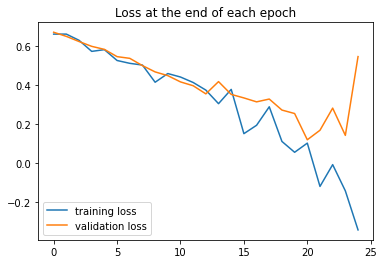

In [65]:
plt.plot(train_losses, label='training loss')
plt.plot(test_losses, label='validation loss')
plt.title('Loss at the end of each epoch')
plt.legend();

In [66]:
inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.225]
)

torch.Size([3, 256, 256])


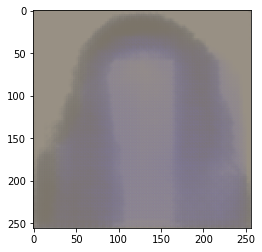

In [67]:
# Testing model
for b, (X_test, y_test) in enumerate(test_dataloader):
  break
testRes=model(X_test)
testRes=torch.squeeze(testRes)
testRes=inv_normalize(testRes)
print(testRes[0].shape)
plt.imshow(np.transpose(testRes[0].detach().numpy(), (1, 2, 0)));